### SQL-Abfragen in Relationale Algebra konvertieren

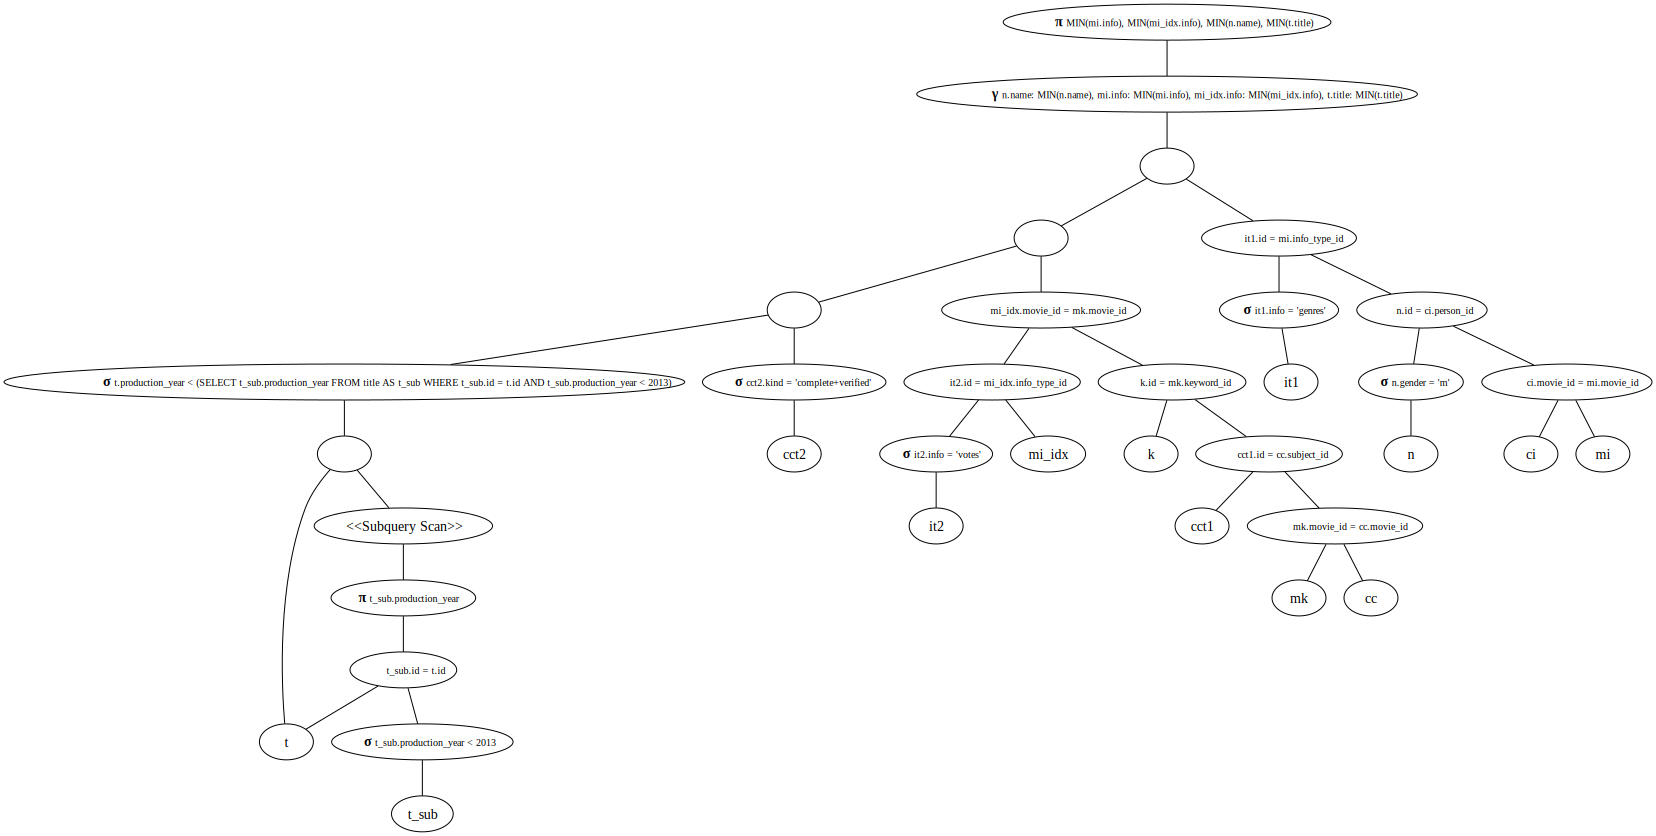

In [9]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

sql_query_3 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE  cct2.kind ='complete+verified'  AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND t.production_year > 2000 AND t.id = mi.movie_id AND t.id = mi_idx.movie_id AND t.id = ci.movie_id AND t.id = mk.movie_id AND t.id = cc.movie_id AND ci.movie_id = mi.movie_id AND ci.movie_id = mi_idx.movie_id AND ci.movie_id = mk.movie_id AND ci.movie_id = cc.movie_id AND mi.movie_id = mi_idx.movie_id AND mi.movie_id = mk.movie_id AND mi.movie_id = cc.movie_id AND mi_idx.movie_id = mk.movie_id AND mi_idx.movie_id = cc.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND cct2.id = cc.status_id AND t.production_year > (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

sql_query_4 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE cct2.kind = 'complete+verified' AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND t.production_year > 2000 AND t.id = mi.movie_id AND ci.movie_id = mi.movie_id AND mi_idx.movie_id = mk.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND t.production_year < (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

sql_query_5 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE cct2.kind = 'complete+verified' AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND ci.movie_id = mi.movie_id AND mi_idx.movie_id = mk.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND t.production_year < (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)
relalg_query_3 = parser.parse_relalg(sql_query_5)
opt_vis.plot_relalg(relalg_query_3)

### Optimierung

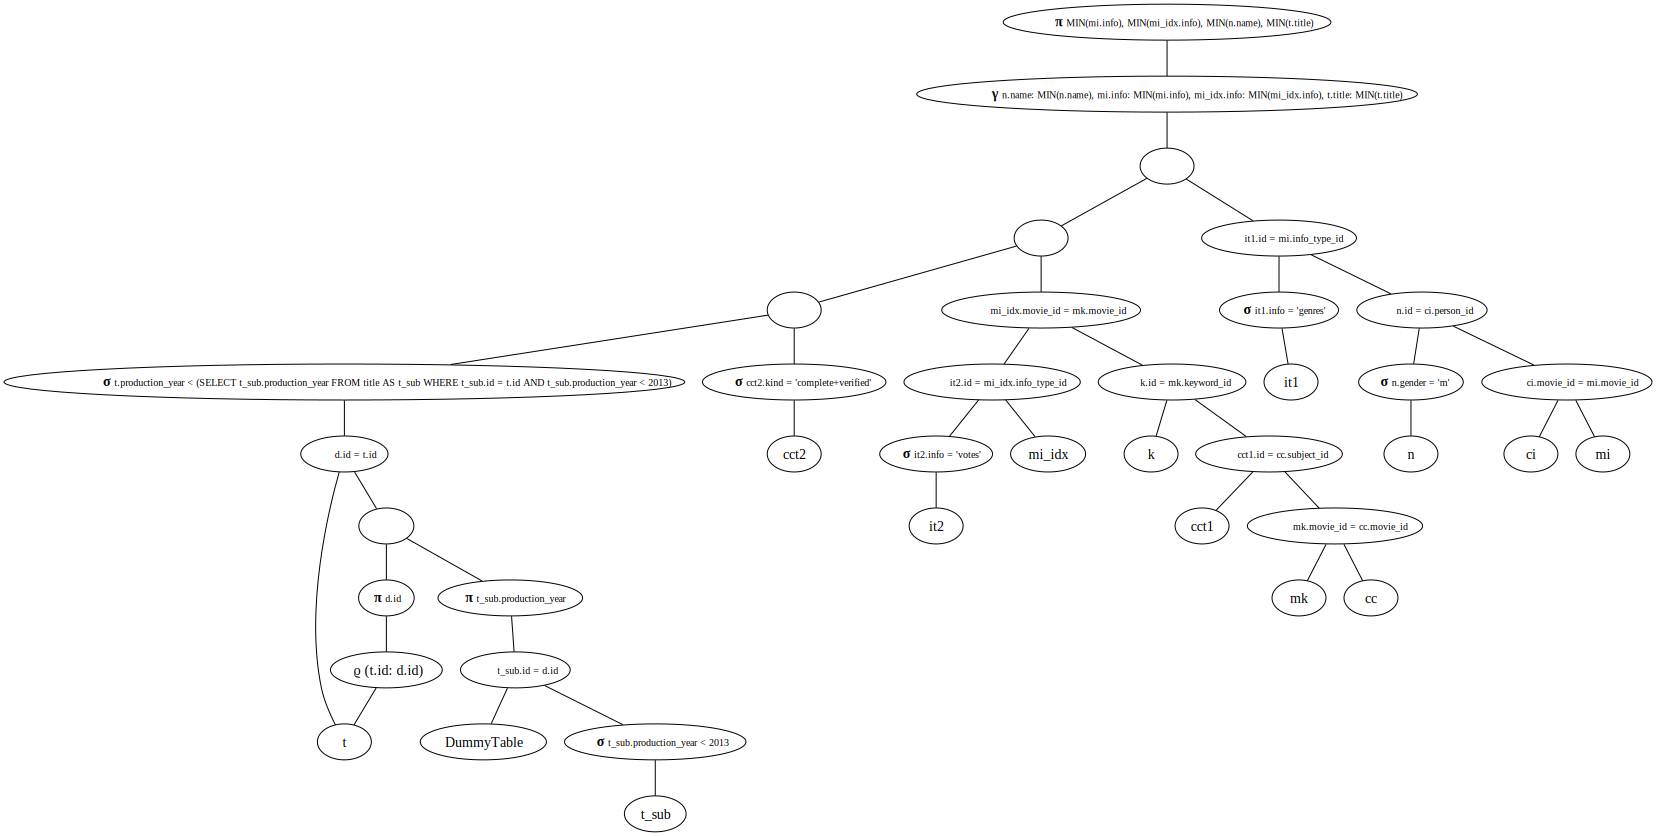

In [10]:
from src.utils.utils import Utils
from src.optimizer.push_down_manager import PushDownManager
from src.optimizer.optimizer import Optimizer

utils = Utils()
pushDownManager = PushDownManager(utils)
optimizer = Optimizer(utils)
result = optimizer.optimize_unnesting(relalg_query_3)

opt_vis.plot_relalg(result)


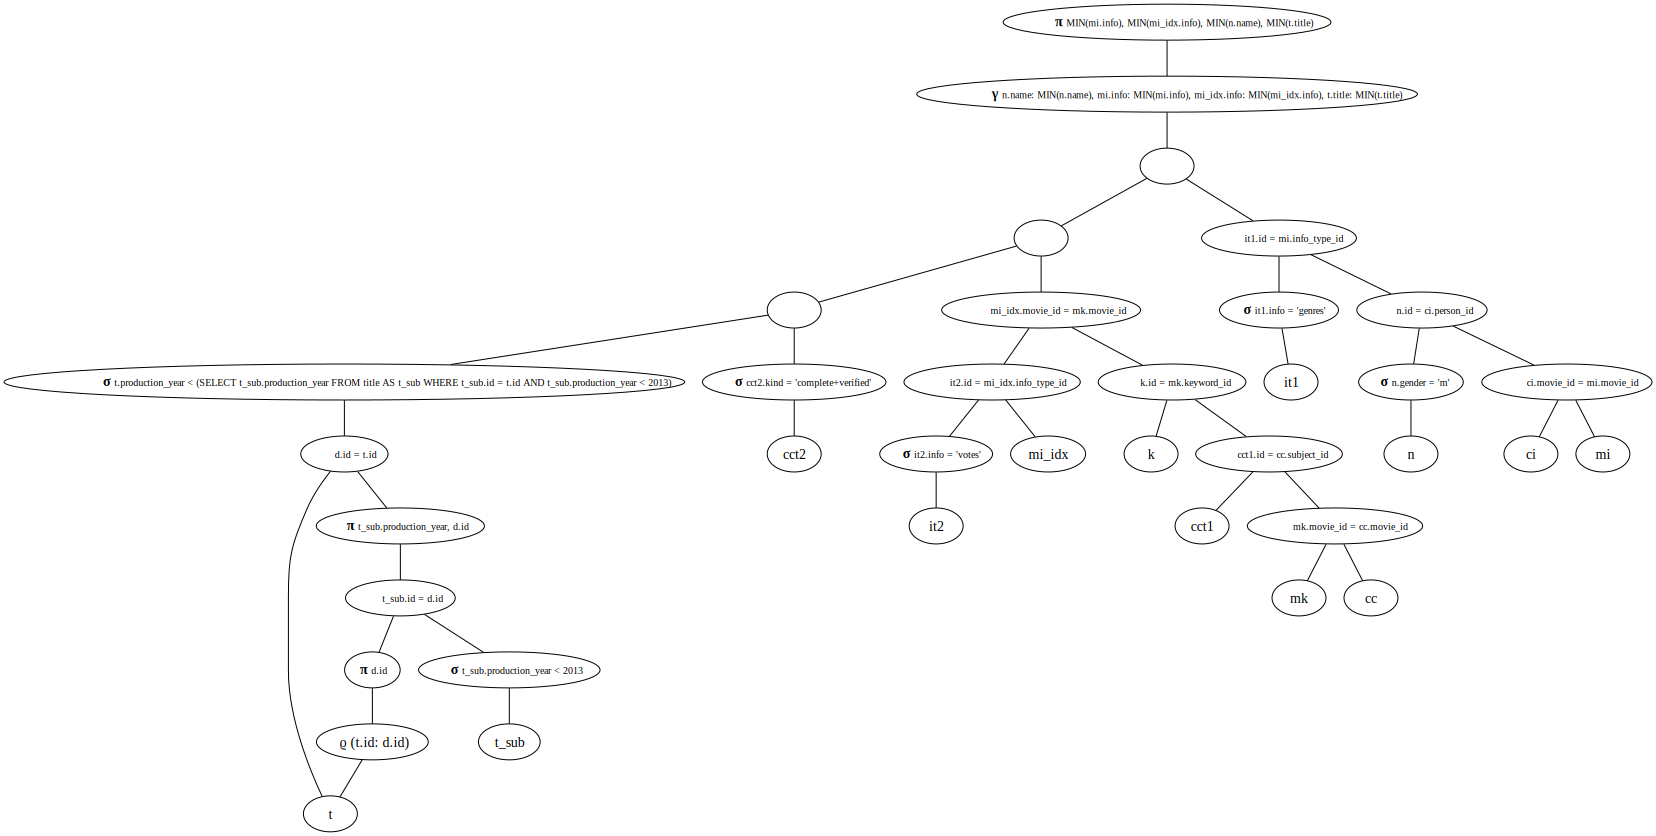

In [11]:
push_down, subquery_root = pushDownManager.push_down(result)
opt_vis.plot_relalg(push_down)

In [12]:
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
print(query_generator.generate_sql_from_relalg(push_down, subquery_root))

WITH outerquery AS (SELECT t.production_year, t.title, t.id FROM title AS t), dup_elim_outerquery AS (SELECT DISTINCT id FROM outerquery) SELECT MIN(mi.info), MIN(mi_idx.info), MIN(n.name), MIN(oq.title) FROM outerquery AS oq, info_type AS it1, comp_cast_type AS cct2, movie_info_idx AS mi_idx, keyword AS k, name AS n, cast_info AS ci, movie_info AS mi, info_type AS it2, comp_cast_type AS cct1, movie_keyword AS mk, complete_cast AS cc, (SELECT t_sub.production_year, d.id FROM dup_elim_outerquery AS d, title AS t_sub WHERE t_sub.id = d.id AND t_sub.production_year < 2013) AS subquery WHERE it1.id = mi.info_type_id AND mi_idx.movie_id = mk.movie_id AND it1.info = 'genres' AND n.id = ci.person_id AND oq.production_year < subquery.production_year AND cct2.kind = 'complete+verified' AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND n.gender = 'm' AND ci.movie_id = mi.movie_id AND it2.info = 'votes' AND cct1.id = cc.subject_id AND mk.movie_id = cc.movie_id AND oq.id = subquery.id;